In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# data of brain MRI and corresponding mask
df_brain = pd.read_csv('data_mask.csv')

In [4]:
df_brain.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

In [5]:
X = []
for i in range(3929):
    img = cv2.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_brain.image_path[i])
    # plt.imshow(img)   
    X.append(img.reshape(-1))

In [6]:
X = np.array(X)

In [7]:
X = X/255

In [8]:
X.shape

(3929, 196608)

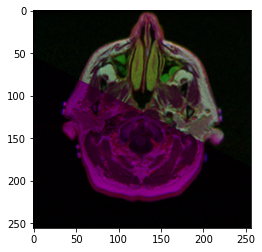

In [9]:
plt.imshow(X[23].reshape(256,256,3))

In [10]:
y = df_brain['mask']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

In [12]:
y_train[:10]

801     0
728     0
586     0
162     0
190     0
2399    1
1259    0
1101    1
2456    1
2860    0
Name: mask, dtype: int64

In [13]:
y_valid[:10]

3687    1
662     0
3483    0
922     0
3823    0
3607    1
1721    1
359     0
2538    1
3327    0
Name: mask, dtype: int64

In [14]:
y_test[:10]

448     0
558     0
248     0
1294    1
1287    0
1182    1
2549    1
1637    1
83      0
92      0
Name: mask, dtype: int64

In [15]:
# define model
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(256*256*3,)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               50331904  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1

In [17]:
# Train the model

#define callbacks
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=20, restore_best_weights=True)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier_resnet_weights_nn.hdf5', 
                               verbose=1, save_best_only=True)

In [18]:
from tensorflow.keras.utils import to_categorical
history = model.fit(X_train,
                    to_categorical(y_train),
                    epochs = 200,  
                    validation_data = (X_valid, to_categorical(y_valid)),
                    batch_size = 16,
                    callbacks=[checkpointer, earlystopping])

Train on 2750 samples, validate on 589 samples
Epoch 1/200
2736/2750 [============================>.] - ETA: 0s - loss: 3.4722 - accuracy: 0.5888
Epoch 00001: val_loss improved from inf to 0.59268, saving model to classifier_resnet_weights_nn.hdf5
2750/2750 [==============================] - 49s 18ms/sample - loss: 3.4580 - accuracy: 0.5891 - val_loss: 0.5927 - val_accuracy: 0.6503
Epoch 2/200
2736/2750 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.6400
Epoch 00002: val_loss improved from 0.59268 to 0.54810, saving model to classifier_resnet_weights_nn.hdf5
2750/2750 [==============================] - 46s 17ms/sample - loss: 0.5892 - accuracy: 0.6389 - val_loss: 0.5481 - val_accuracy: 0.6587
Epoch 3/200
2736/2750 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.6404
Epoch 00003: val_loss improved from 0.54810 to 0.53163, saving model to classifier_resnet_weights_nn.hdf5
2750/2750 [==============================] - 38s 14ms/sample - loss:

In [19]:
# make prediction
test_predict = model.predict(X_test, #steps=test_generator.n//16, 
                             verbose=False)
test_predict

array([[1.0000000e+00, 6.5769293e-11],
       [1.0000000e+00, 1.5491504e-10],
       [9.9968386e-01, 3.1620442e-04],
       ...,
       [9.9965894e-01, 3.4109305e-04],
       [3.4040317e-01, 6.5959680e-01],
       [3.4040317e-01, 6.5959680e-01]], dtype=float32)

In [20]:
"""Model evaluation"""
# obtain the predicted class from model prediction (probability)
y_predict = []
for i in test_predict:
    y_predict.append(np.argmax(i))
y_predict = np.asarray(y_predict)
y_predict[:10]

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0], dtype=int64)

In [21]:
y_test[:10]

448     0
558     0
248     0
1294    1
1287    0
1182    1
2549    1
1637    1
83      0
92      0
Name: mask, dtype: int64

0.8220
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       394
           1       0.67      0.93      0.78       196

    accuracy                           0.82       590
   macro avg       0.81      0.85      0.81       590
weighted avg       0.86      0.82      0.83       590



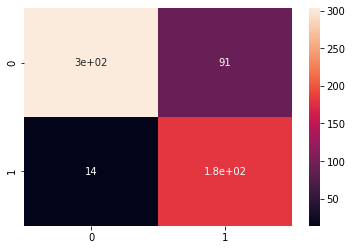

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_predict)
print('%.4f'%accuracy)

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

print(classification_report(y_test, y_predict))